<div style="font-weight: bold; color:#00a55b" align="center">
    <div style="font-size: xx-large"></div>Aplicaciones de Análisis - Máster en Big Data y Data Science<br> <br>
    <div style="font-size: x-large; color:#A5644E">Práctica de Series Temporales: Energía Eólica</div><br>
    <div style="font-size: large">AUTOR</div><br></div><hr>
</div>

**Configuración**

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import adfuller, kpss

from os.path import isfile

En esta práctica vamos a analizar y predecir la **energía eólica del parque eólico Sotavento** como una serie temporal.
Para ello se debe utilizar el archivo [Eolica.csv](https://formacion.uam.es/pluginfile.php/449731/mod_assign/introattachment/0/Eolica.csv?forcedownload=1) disponible en Moodle donde encontraréis tres años de datos diarios, con la siguiente información:

* Fecha (dd/mm/aaaa)
* Velocidad del viento (m/s)
* Dirección del viento
* Energía eólica producida (Kw/día)

Es interesante conocer que la potencia instalada de este parque es de $17560Kwh$, de forma que en lugar de utilizar como objetivo la energía en Kw podamos utilizar un porcentaje de potencia, ya que son números más intuitivos y manejables. Cuidado porque al ser datos diarios, esta cantidad se debe multiplicar por $24h$ para escalar los datos.

# Carga de datos

Cargamos los datos.

In [2]:
eolica = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 3], dayfirst=True).squeeze()
eolica

Date
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
                ...    
2018-12-27     10872.37
2018-12-28     18077.52
2018-12-29     85855.44
2018-12-30     63911.85
2018-12-31     31660.28
Name: WindEnergy, Length: 1096, dtype: float64

# Análisis de la serie temporal (5 puntos)

**Ejercicio:**

* Analizar las características de la serie temporal (visualización, análisis estadístico, estacionariedad, autocorrelaciones) para detectar comportamientos particulares de la energía.
* Preprocesado los datos, detectando y rellenando posibles huecos, así como haciendo la serie estacionaria si fuese necesario.

In [3]:
eolica.describe()

count      1088.000000
mean      68592.571756
std       70408.721701
min           0.000000
25%       15139.600000
50%       43866.700000
75%      100261.447500
max      354637.160000
Name: WindEnergy, dtype: float64

In [4]:
# See the first 10 rows and the last 10 rows
print("The first 10 rows of the dataset")
print(eolica.head(10))
print()
print("The last 10 rows of the dataset")
print(eolica.tail(10))

The first 10 rows of the dataset
Date
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
2016-01-06    278101.80
2016-01-07    247007.30
2016-01-08          NaN
2016-01-09          NaN
2016-01-10          NaN
Name: WindEnergy, dtype: float64

The last 10 rows of the dataset
Date
2018-12-22    95918.79
2018-12-23    43276.21
2018-12-24    13585.14
2018-12-25    18349.89
2018-12-26    21548.11
2018-12-27    10872.37
2018-12-28    18077.52
2018-12-29    85855.44
2018-12-30    63911.85
2018-12-31    31660.28
Name: WindEnergy, dtype: float64


Aplicamos normalizacion, por lo que definimos PI como $17560Kwh$ y multiplicamos por 24 horas

In [5]:
# Apply Normalization
PI = 17560
eolica = eolica / (PI*24)
eolica

Date
2016-01-01    0.665828
2016-01-02    0.431808
2016-01-03    0.781774
2016-01-04    0.514207
2016-01-05    0.486095
                ...   
2018-12-27    0.025798
2018-12-28    0.042895
2018-12-29    0.203719
2018-12-30    0.151651
2018-12-31    0.075124
Name: WindEnergy, Length: 1096, dtype: float64

## Visualización

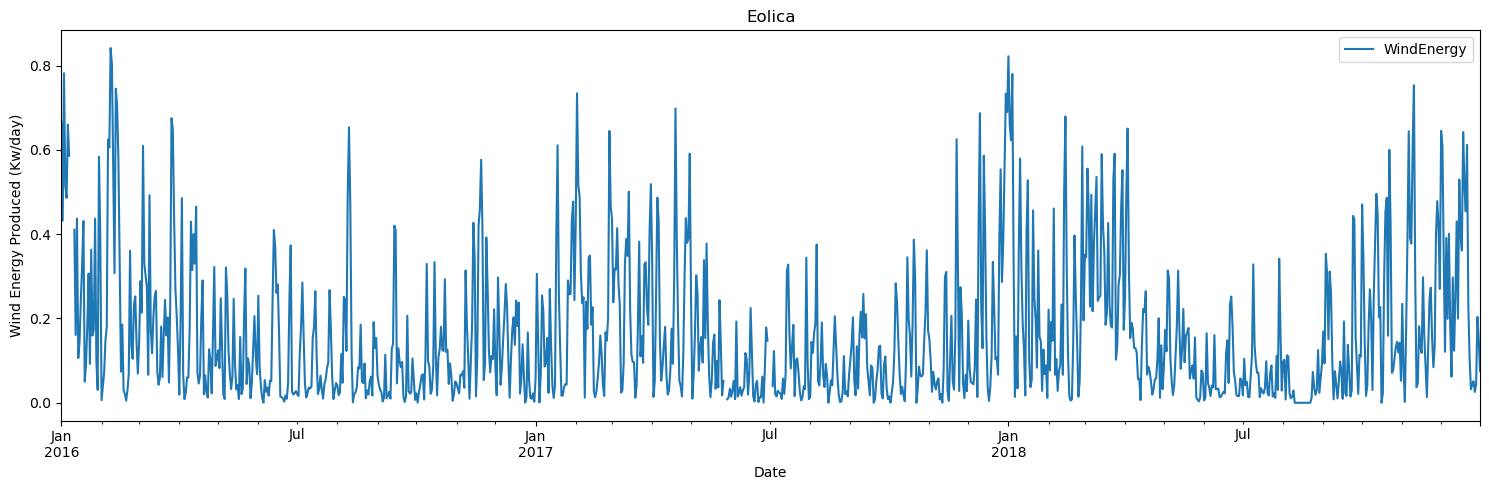

In [6]:
plt.figure()
eolica.plot()
plt.title('Eolica')
plt.xlabel('Date')
plt.ylabel('Wind Energy Produced (Kw/day)')
plt.legend()
plt.tight_layout()
plt.show()

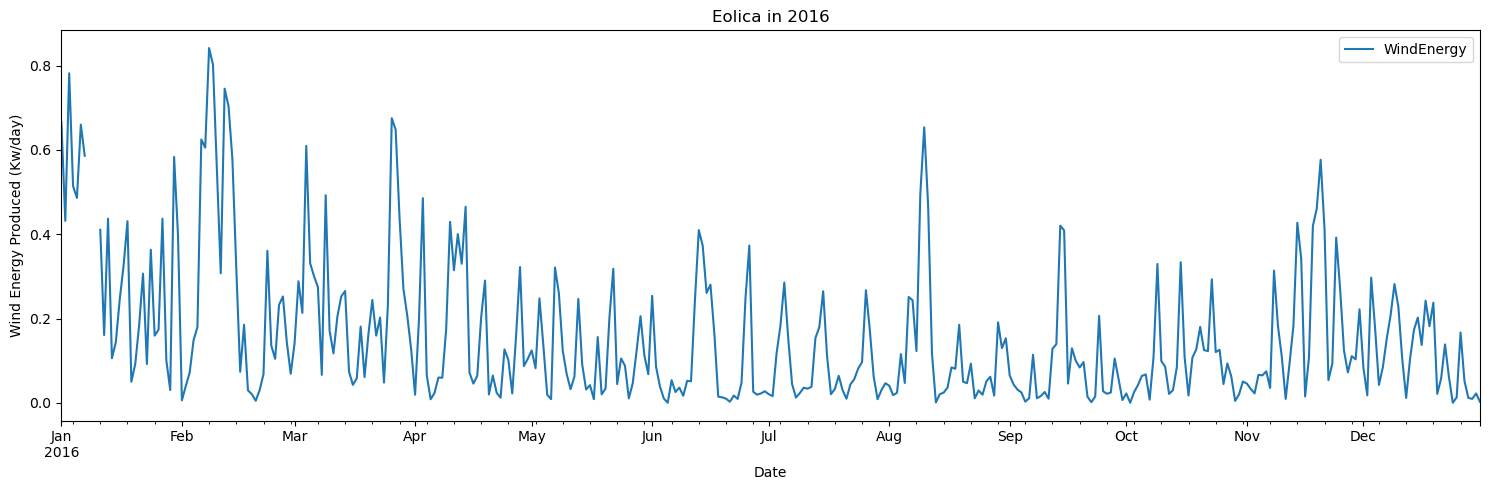

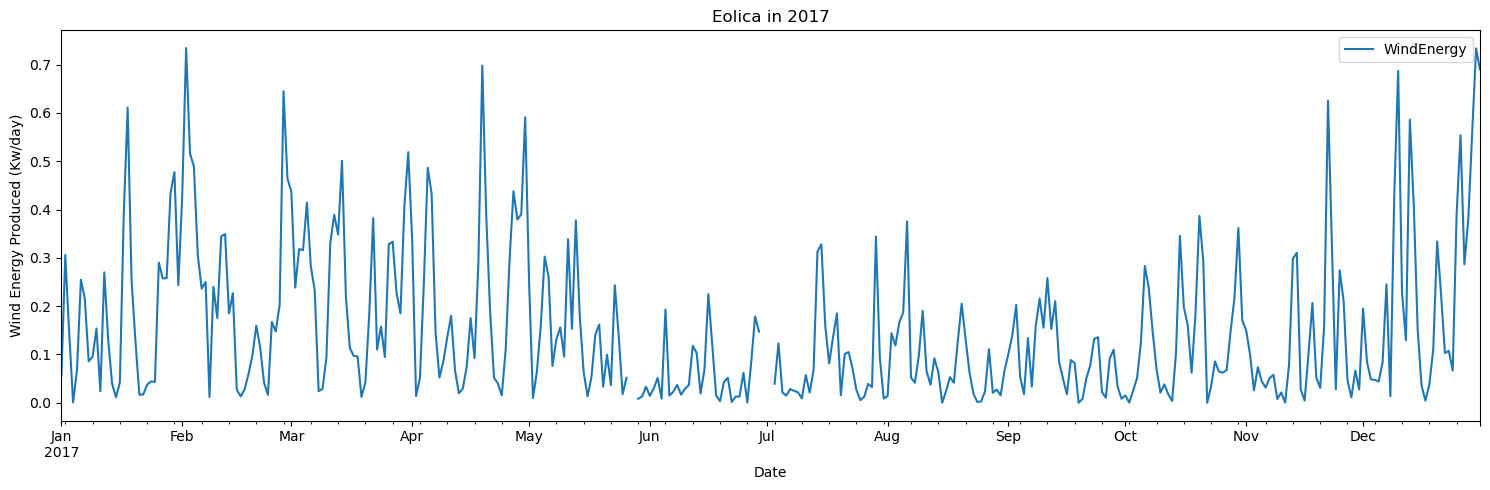

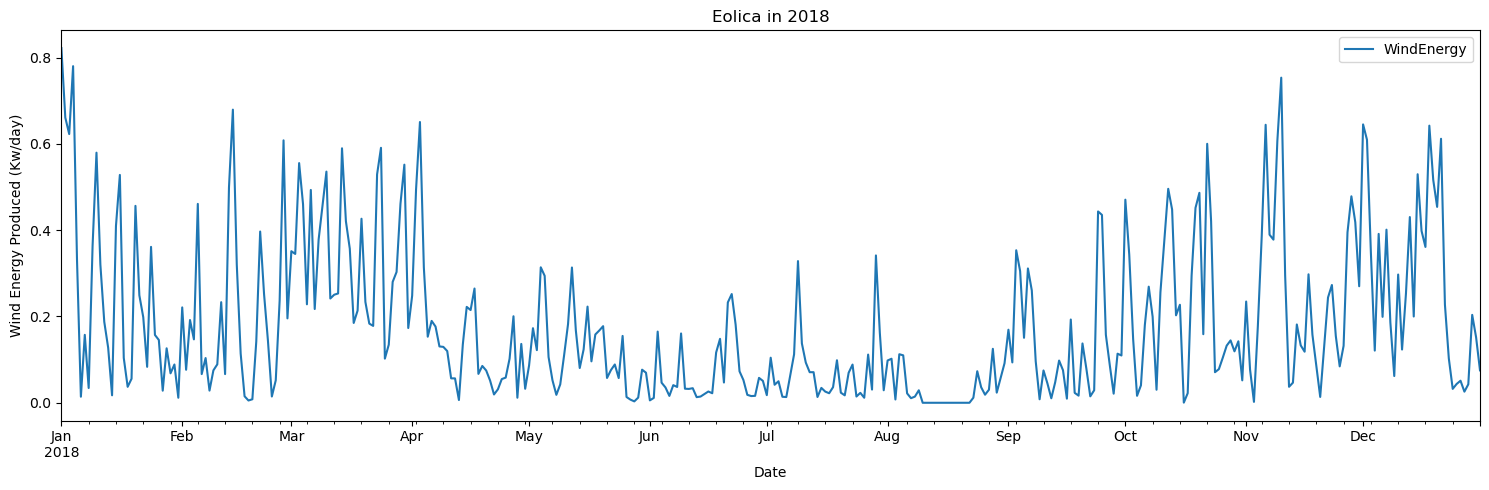

In [7]:
plt.figure()
eolica['2016'].plot()
plt.title('Eolica in 2016')
plt.xlabel('Date')
plt.ylabel('Wind Energy Produced (Kw/day)')
plt.legend()
plt.tight_layout()
plt.figure()
eolica['2017'].plot()
plt.title('Eolica in 2017')
plt.xlabel('Date')
plt.ylabel('Wind Energy Produced (Kw/day)')
plt.legend()
plt.tight_layout()
plt.figure()
eolica['2018'].plot()
plt.title('Eolica in 2018')
plt.xlabel('Date')
plt.ylabel('Wind Energy Produced (Kw/day)')
plt.legend()
plt.tight_layout()
plt.show()

## Análisis estadístico y preproceso de los datos

In [8]:
# Missing values
eolica.isna().any()

True

Para rellenar los huecos hacemos una interpolación lineal en lo datos. Se trata de un método que conecta puntos adyacentes con una línea recta.

In [9]:
# Fill the missing values with the function interpolate of pandas
eolica_2 = eolica.interpolate()
eolica_2.isna().any()

False

In [10]:
eolica = eolica_2

## Análisis de tendencia y estacionalidad
### Seasonal Decompose

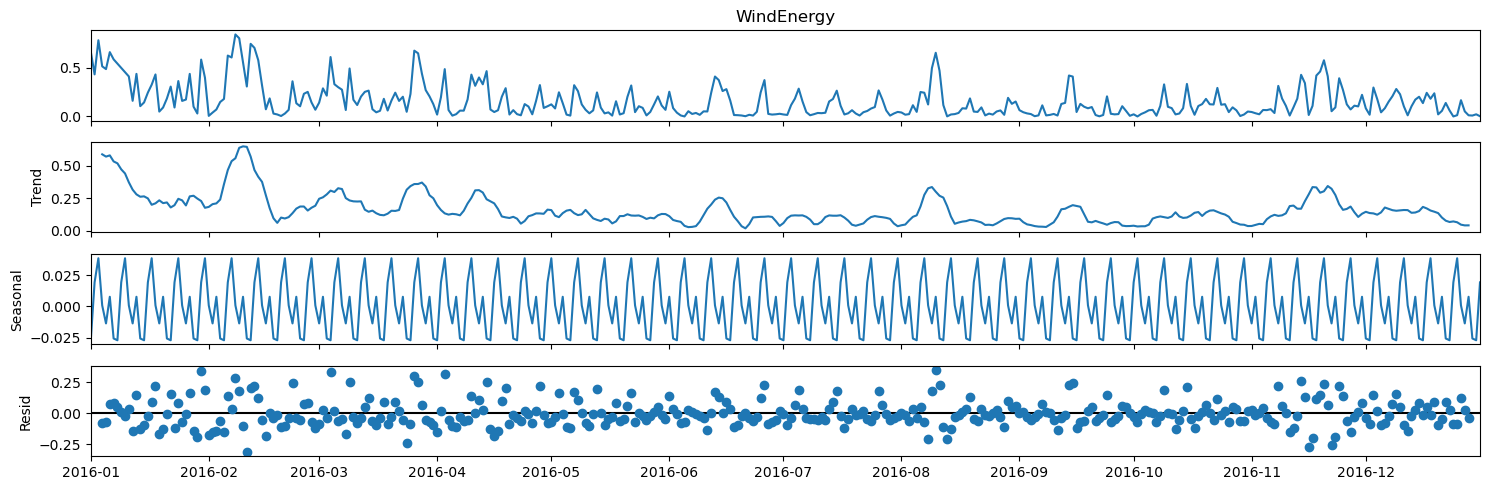

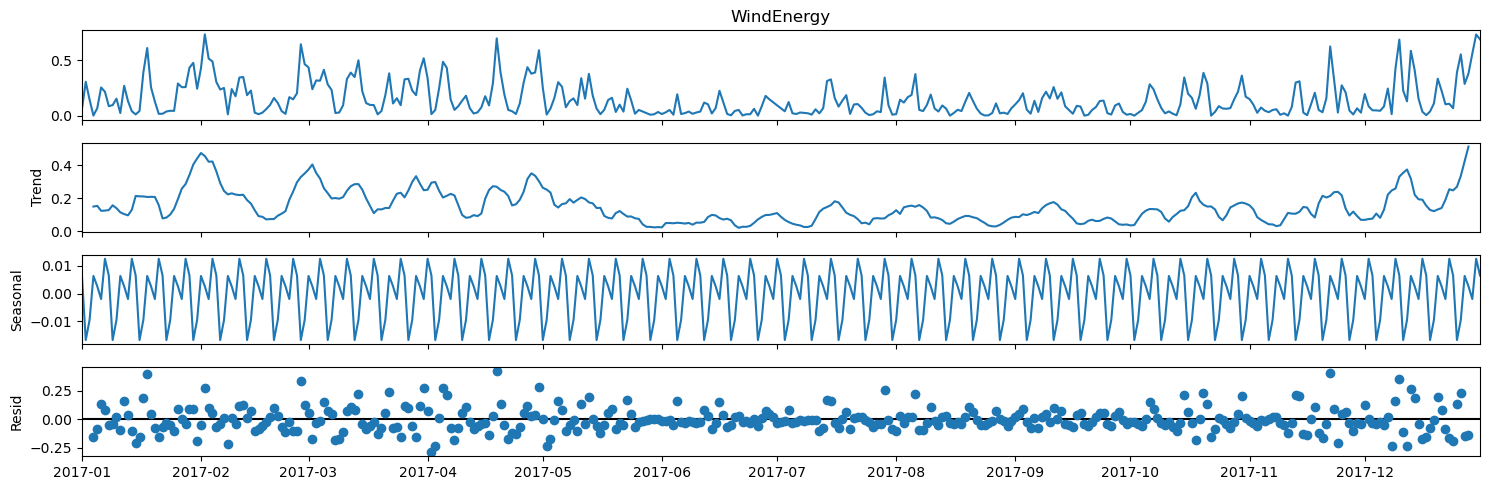

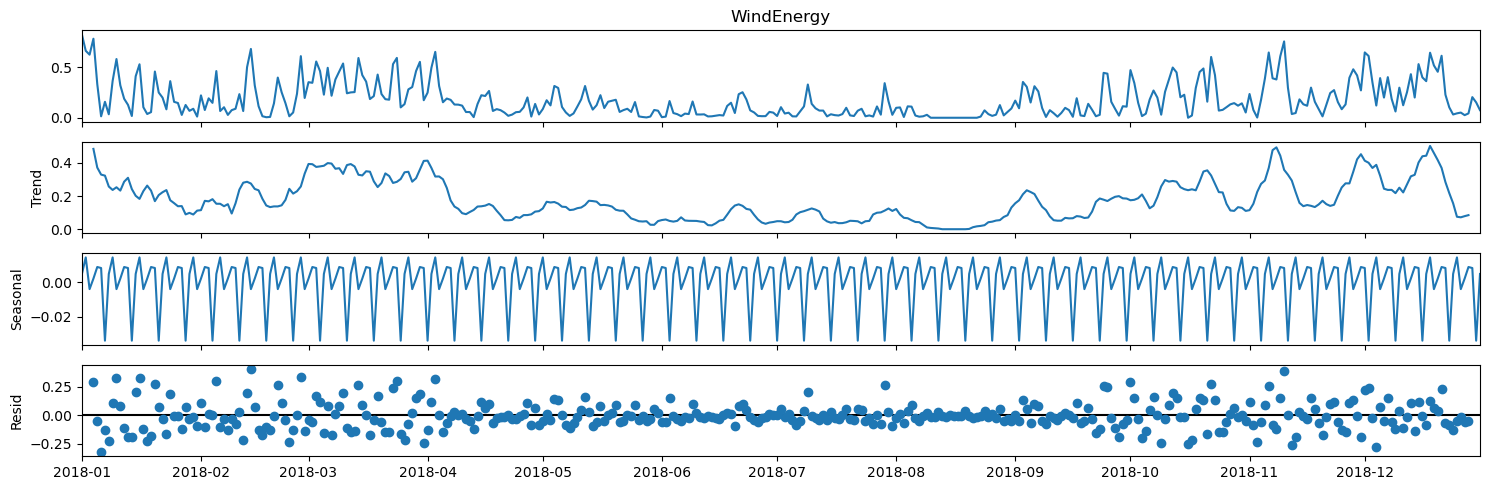

In [11]:
# Seasonal decomposition for each year
def plot_seasonal_decomposition(eolica_year):
    result = tsa.seasonal_decompose(eolica_year, model='additive', period=7)
    result.plot()
    plt.show()

# Analyze trend and seasonality for each year
eolica_2016 = eolica['2016']
eolica_2017 = eolica['2017']
eolica_2018 = eolica['2018']

plot_seasonal_decomposition(eolica_2016)
plot_seasonal_decomposition(eolica_2017)
plot_seasonal_decomposition(eolica_2018)

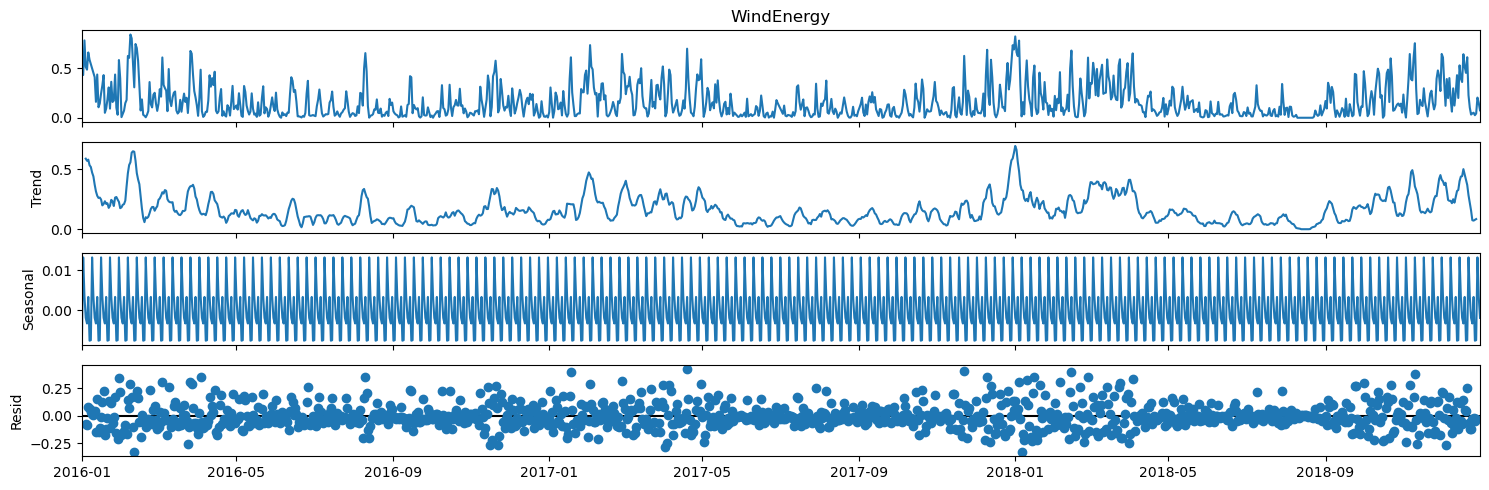

In [12]:
decomposed_results = tsa.seasonal_decompose(eolica, model='additive', period=7)
decomposed_results.plot()
plt.show()


El gráfico de tendencias puede revelar si la producción de energía eólica aumenta, disminuye o se mantiene estable a lo largo del tiempo. Esto puede deberse a factores como el aumento de la capacidad de los parques eólicos o los cambios en los patrones del viento. Vemos que la producción de energía eólica aumenta en los meses de invierno.

### Test ADF

Las hipótesis del test ADF:
* *Hipótesis nula*: La ST es no estacionaria.
* *Hipótesis alternativa*: La serie es estacionaria.

In [13]:
dftest = adfuller(eolica)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

if dftest[1] > 0.05:
    print('It is not Stationary')
else:
    print('It is Stationary')

Test Statistic                   -4.142392
p-value                           0.000824
#Lags Used                       20.000000
Number of Observations Used    1075.000000
Critical Value (1%)              -3.436448
Critical Value (5%)              -2.864232
Critical Value (10%)             -2.568204
dtype: float64
It is Stationary


En este caso el estadístico de la prueba ADF es más negativo que el valor crítico, rechazamos la hipótesis nula y concluimos que los datos son probablemente estacionarios.

### Test KPSS

Las hipótesis del test KPSS:
* *Hipótesis nula*: La ST es estacionaria, pero con tendencia.
* *Hipótesis alternativa*: La serie es no estacionaria.

In [14]:
kpsstest = kpss(eolica)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

if kpsstest[1] < 0.05:
    print('It is not Stationary')
else:
    print('It is Stationary')

Test Statistic            0.191381
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
It is Stationary


/tmp/ipykernel_176460/881937953.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(eolica)


En este caso el estadístico de la prueba KPSS es menor o igual que el valor crítico, no rechazamos la hipótesis nula y consideramos que los datos son potencialmente estacionarios.

La serie es **ESTACIONARIA** acorde a los tests!!

---

## Análisis de ACF y PACF

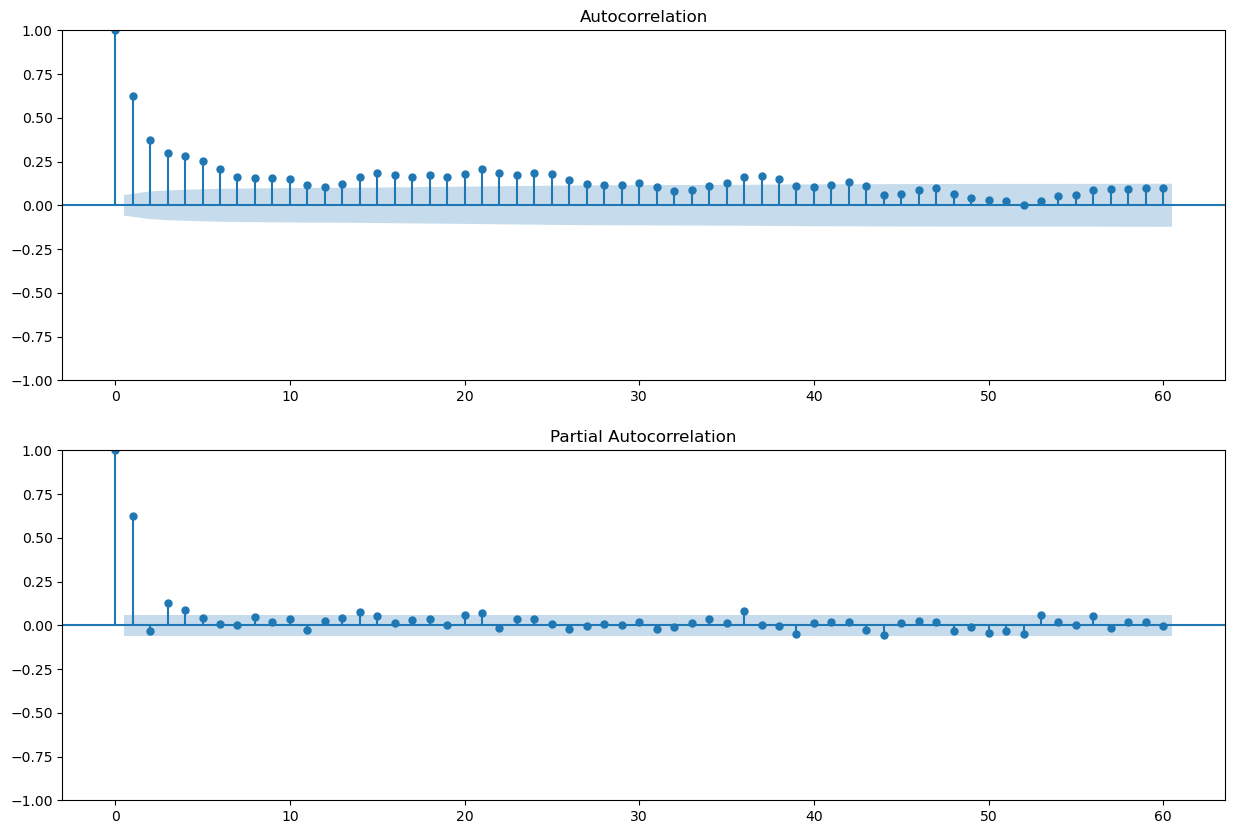

In [15]:
# Plot ACF y PACF in subplots
fig, ax = plt.subplots(2, figsize=(15, 10))
tsaplots.plot_acf(eolica, lags=60, ax=ax[0])
tsaplots.plot_pacf(eolica, lags=60, ax=ax[1])
plt.show()

El gráfico ACF muestra un descenso gradual tras una caída inicial, lo que sugiere un proceso AR(p) (donde "p" es el orden de los términos autorregresivos). Ya que no se aproxima rápidamente a 0, podemos utilizar SARIMA.

El gráfico PACF tiene un pico significativo en el lag 1 y luego fluctúa alrededor de cero, lo que indica que un modelo ARIMA podría ser apropiado.

También podemos usar SARIMAX y ARIMAX para incluir variables exógenas que influyen en la serie temporal.

# Predicción de la serie temporal (5 puntos)

**Ejercicio:**

* Dividir la ST en un conjunto de entrenamiento (año 2016), un conjunto de validación (año 2017) y un conjunto de test (año 2018).
* Probar distintos modelos para predecir a distintos horizontes. Estos modelos deben ejecutarse con los parámetros adecuados, por lo que será buena idea hacer una validación de los modelos y probar hiperparámetros con una búsqueda en rejilla siempre que sea posible.
* Justificar los modelos elegidos y analizar los resultados mediante una comparativa de los errores obtenidos por cada modelo, explicando por qué sale mejor un modelo que otro para este problema concreto, además de analizar la degradación del modelo según aumentamos el horizonte, ¿cuánto aguanta el mejor modelo?
* ¿Sería interesante añadir variables exógenas? ¿Qué variables aportan información para la predicción de la energía eólica?

## Predicción utilizando Modelos Clásicos
### División en conjuntos de entrenamiento, validación y predicción

In [16]:
s_tr = eolica['2016']
s_va = eolica['2017']
s_te = eolica['2018']

n_tr = len(s_tr)
n_va = len(s_va)
n_te = len(s_te)

print("Number of samples in the training set: ", n_tr)
print("Number of samples in the validation set: ", n_va)
print("Number of samples in the test set: ", n_te)

Number of samples in the training set:  366
Number of samples in the validation set:  365
Number of samples in the test set:  365


Vemos los valores estadisticos

In [17]:
s_tr.describe()

count    366.000000
mean       0.161007
std        0.170666
min        0.000339
25%        0.034269
50%        0.101451
75%        0.236508
max        0.841489
Name: WindEnergy, dtype: float64

In [18]:
s_va.describe()

count    365.000000
mean       0.151004
std        0.153885
min        0.000002
25%        0.034173
50%        0.096975
75%        0.224841
max        0.734208
Name: WindEnergy, dtype: float64

In [19]:
s_te.describe()

count    365.000000
mean       0.177727
std        0.176569
min        0.000000
25%        0.037059
50%        0.119212
75%        0.252990
max        0.821950
Name: WindEnergy, dtype: float64

## Entrenamiento

Definimos una función SARIMAX_train para entrenar los datos.

In [20]:
# Define the function to train SARIMAX model
def SARIMAX_train(s, order, n_tr, period=0, seasonal_order=(0,0,0,0), exog=None):
    s_aux = s.copy()
    if (period != 0):
        s_aux = s_aux.diff(periods=period)
    
    if exog is None:
        exogTrain = None
    else:
        exogTrain = exog[:n_tr].to_numpy()
        
    tr_mod = sm.tsa.SARIMAX(s_aux[:n_tr].to_numpy(), exog=exogTrain, 
                            order=order, seasonal_order=seasonal_order, enforce_stationarity=True)
    #The parameter values are estimated using just the training data
    tr_res = tr_mod.fit()

    #Extend the parameters to the whole series
    if exog is None:
        exogExtend = None
    else:
        exogExtend = exog.to_numpy()
        
    res = tr_res.extend(s_aux.to_numpy(), exog=exogExtend)
    
    return res

In [22]:
p = 0
q = 1
n_hours=24
mod = SARIMAX_train(eolica, (p, 1, q), n_tr+n_va)
print(mod.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.71215D-01    |proj g|=  9.36396D-02

At iterate    5    f= -5.76932D-01    |proj g|=  1.89822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      1     0     0   3.355D-05  -5.769D-01
  F = -0.57693177540992147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


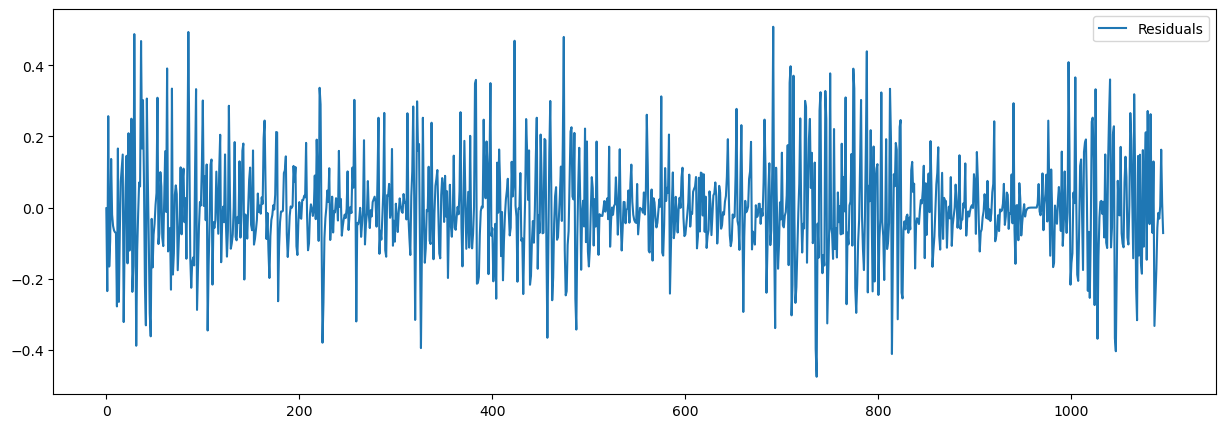

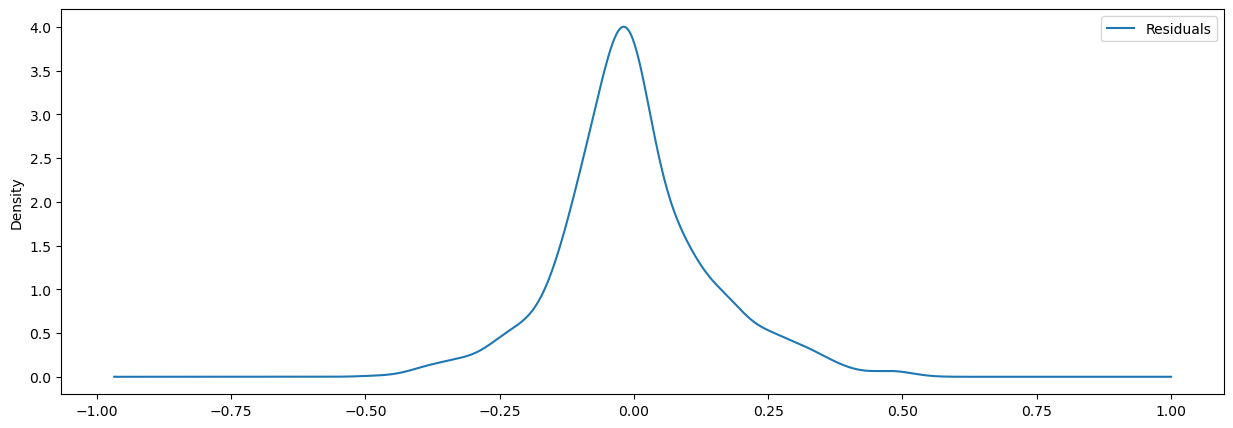

In [23]:
residuals = pd.DataFrame(mod.resid, columns=['Residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

In [24]:
residuals.describe()

,Residuals
count,1096.000000
mean,-0.000853
std,0.139417
min,-0.475734
25%,-0.076735
50%,-0.013165
75%,0.066681
max,0.508288


## Predicción

In [25]:
def SARIMAX_predict(model, s, start, end, horizon=0, period=0):
    if horizon == 0:
        pred = model.predict(start=start, end=end - 1, dynamic=False)
    else:
        pred = []
        for i in range(start, end):
            print('\r\tComputing... (%5d / %5d)' % (i, end), end='')
            pred.append(model.predict(start=i-horizon, end=i, dynamic=True)[horizon])
        pred = np.array(pred)
        print('\r%50s\r' % ' ', end='')
    if (period != 0):
        return pred + s[start - period:end - period].to_numpy()
    else:
        return pred

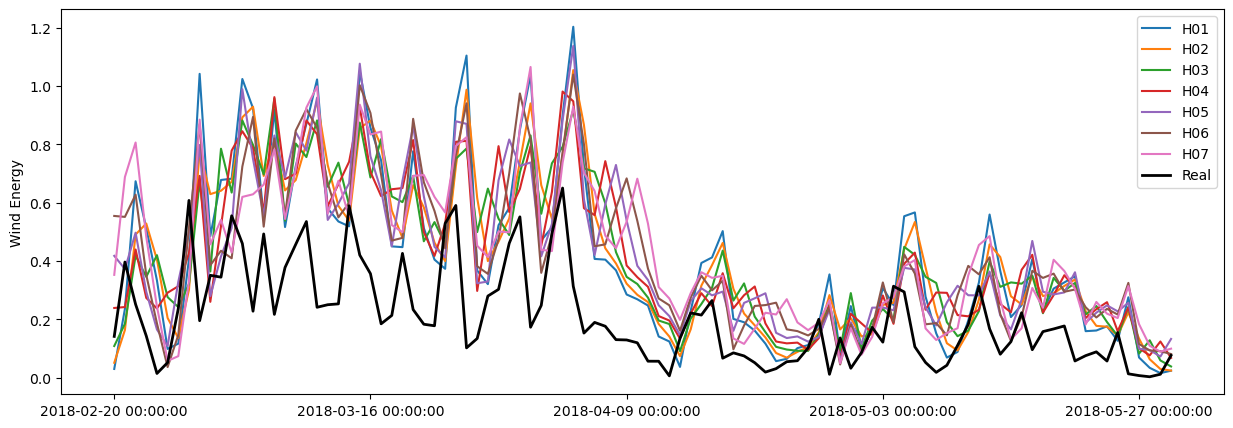

In [26]:
# Carpeta de salida
# matplotlib.use('TkAgg')
output_folder='./Output'

n_horizon=7
# n_hours=24

start=n_tr + n_va
end=n_tr + n_va + n_te


for h in range(n_horizon):
    file = '%s/pred0_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h)  # period=n_hours
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))
    
# While predicting, plot the first 100 points as an example
y = eolica[start + 50 : start + 150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

## Evaluación

In [27]:
def errors_by_day(true, pred, MAE=True):
    ind = true.index
    ind_day = ind.date  # Extract the date component
    unique_days = sorted(set(ind_day))  # Get unique days

    if MAE:
        maes = [mean_absolute_error(true, pred)]
        for day in unique_days:
            maes.append(mean_absolute_error(true[ind_day == day].to_numpy(), pred[ind_day == day]))
        return unique_days, maes
    else:
        mses = [mean_squared_error(true, pred)]
        for day in unique_days:
            mses.append(mean_squared_error(true[ind_day == day].to_numpy(), pred[ind_day == day]))
        return unique_days, mses

maes_h = []
n_horizon = 7
for h in range(n_horizon):
    file = f'{output_folder}/pred0_H{h:02d}.npy'
    if isfile(file):
        pred = np.load(file)
    days, maes = errors_by_day(eolica[start:end], pred, MAE=True)
    maes_h.append(maes)

horizon = 0
print('Total MAE: %.2f' % maes_h[horizon][0])
for day in days:
    print(f'MAE {day}: %.2f' % maes_h[horizon][days.index(day) + 1])


Total MAE: 0.22
MAE 2018-01-01: 0.54
MAE 2018-01-02: 0.92
MAE 2018-01-03: 0.74
MAE 2018-01-04: 0.50
MAE 2018-01-05: 1.18
MAE 2018-01-06: 0.81
MAE 2018-01-07: 0.06
MAE 2018-01-08: 0.30
MAE 2018-01-09: 0.24
MAE 2018-01-10: 0.04
MAE 2018-01-11: 0.71
MAE 2018-01-12: 0.50
MAE 2018-01-13: 0.32
MAE 2018-01-14: 0.29
MAE 2018-01-15: 0.31
MAE 2018-01-16: 0.16
MAE 2018-01-17: 0.85
MAE 2018-01-18: 0.30
MAE 2018-01-19: 0.10
MAE 2018-01-20: 0.32
MAE 2018-01-21: 0.51
MAE 2018-01-22: 0.32
MAE 2018-01-23: 0.34
MAE 2018-01-24: 0.14
MAE 2018-01-25: 0.48
MAE 2018-01-26: 0.22
MAE 2018-01-27: 0.29
MAE 2018-01-28: 0.01
MAE 2018-01-29: 0.17
MAE 2018-01-30: 0.06
MAE 2018-01-31: 0.16
MAE 2018-02-01: 0.17
MAE 2018-02-02: 0.29
MAE 2018-02-03: 0.01
MAE 2018-02-04: 0.20
MAE 2018-02-05: 0.16
MAE 2018-02-06: 0.73
MAE 2018-02-07: 0.14
MAE 2018-02-08: 0.21
MAE 2018-02-09: 0.02
MAE 2018-02-10: 0.06
MAE 2018-02-11: 0.06
MAE 2018-02-12: 0.34
MAE 2018-02-13: 0.32
MAE 2018-02-14: 0.16
MAE 2018-02-15: 0.91
MAE 2018-02-16: 0.

El MAE mide la magnitud media de la diferencia entre los valores predichos y los valores reales en nuestro conjunto de datos. Calcula la diferencia absoluta (sin tener en cuenta la dirección) de cada predicción y, a continuación, la media de todos los puntos de datos.

Por tanto, dado que los valores MAE son muy pequeños, podemos afirmar que la predicción es acertada.

MAE Total H01: 0.22
MAE Total H02: 0.22
MAE Total H03: 0.21
MAE Total H04: 0.21
MAE Total H05: 0.22
MAE Total H06: 0.22
MAE Total H07: 0.22


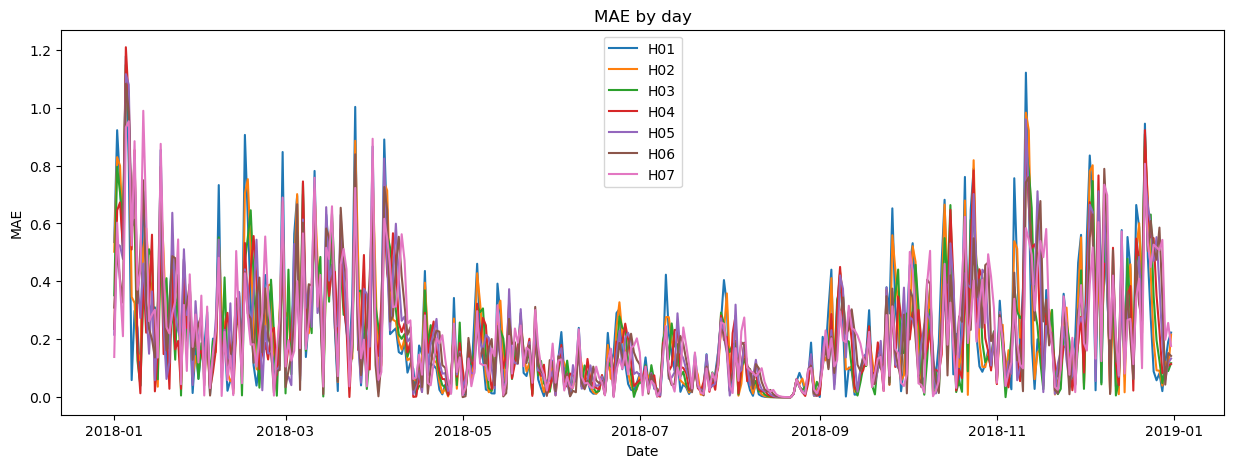

In [28]:
n_horizon = 7

maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]

# Assuming you have a list of unique days (replace with your actual data)
unique_days = [pd.Timestamp(day) for day in days]

for h in range(n_horizon):
    plt.plot(unique_days, maes[h, :], label=f'H{h + 1:02d}')
    print(f'MAE Total H{h + 1:02d}: %.2f' % maes_t[h])

plt.xlabel("Date")  
plt.ylabel("MAE")   
plt.title("MAE by day")
plt.legend()
plt.show()

## Búsqueda de hiperparámetros

In [29]:
def validate(horizon, s, n_tr, n_va, period=0):
    vec_p = np.arange(10)
    vec_q = np.arange(10)
    
    best_e = np.inf
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for p in vec_p:
        for q in vec_q:
            try:
                model = SARIMAX_train(s, (p, 0, q), n_tr, period=period)
                pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=period)
                e = mean_absolute_error(true, pred)
            except Exception as exc:
                e = np.inf
            if (e < best_e):
                best_e = e
                best_p = p
                best_q = q
            
            print('%d %d => %.4f' % (p, q, e))
    
    order = (best_p, 0, best_q)
    print('\tBest:', order)

    return order



def validate_seasonal(horizon, s, n_tr, n_va, p, d, q, per):
    vec_P = np.arange(3)
    vec_Q = np.arange(2)
    vec_D = np.arange(2)
    
    best_e = np.inf
    best_P, best_D, best_Q = None, None, None  # Initialize the variables
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for P in vec_P:
        for Q in vec_Q:
            for D in vec_D:
                try:
                    print("TRAIN %d %d % d" % (P, D, Q))
                    model = SARIMAX_train(s, (p, d, q), n_tr, period=0, seasonal_order=(P, D, Q, per))
                    print("PRED")
                    pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=0)
                    e = mean_absolute_error(true, pred)
                except Exception as exc:
                    e = np.inf
                if e < best_e:
                    best_e = e
                    best_P, best_D, best_Q = P, D, Q  # Update the best values
            
                print('%d %d %d => %.4f' % (P, D, Q, e))
    
    seasonal_order = (best_P, best_D, best_Q, per)
    print('\tBest:', seasonal_order)

    return seasonal_order

In [30]:
file = '%s/order.npy' % (output_folder)
if isfile(file):
    order = np.load(file)
    print(order)
else:
    order = validate(0, eolica, n_tr, n_va - 6)
    np.save(file, order)

p=1
d=0
q=0

per=1 #Cada 1 dato es un ciclo

file = '%s/sarima_order.npy' % (output_folder)
if isfile(file):
    seasonal_order = np.load(file, allow_pickle=True)

    print(seasonal_order)
else:
    seasonal_order = validate_seasonal(0, eolica, n_tr, n_va - 6, p, d, q, per)
    np.save(file, seasonal_order)

[6 0 4]
[None None None 1]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47678D+02    |proj g|=  5.59521D+03

At iterate    5    f=  1.05523D+00    |proj g|=  7.58542D-01


/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  2.72814D-01    |proj g|=  1.75837D+00

At iterate   15    f= -5.33592D-01    |proj g|=  1.79374D+00

At iterate   20    f= -6.57993D-01    |proj g|=  6.19389D-01

At iterate   25    f= -6.64222D-01    |proj g|=  9.38965D-02

At iterate   30    f= -6.65254D-01    |proj g|=  4.14335D-03

At iterate   35    f= -6.65518D-01    |proj g|=  1.02239D-02

At iterate   40    f= -6.66109D-01    |proj g|=  4.28956D-02

At iterate   45    f= -6.66442D-01    |proj g|=  6.00997D-03

At iterate   50    f= -6.66476D-01    |proj g|=  3.91813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     66   

/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


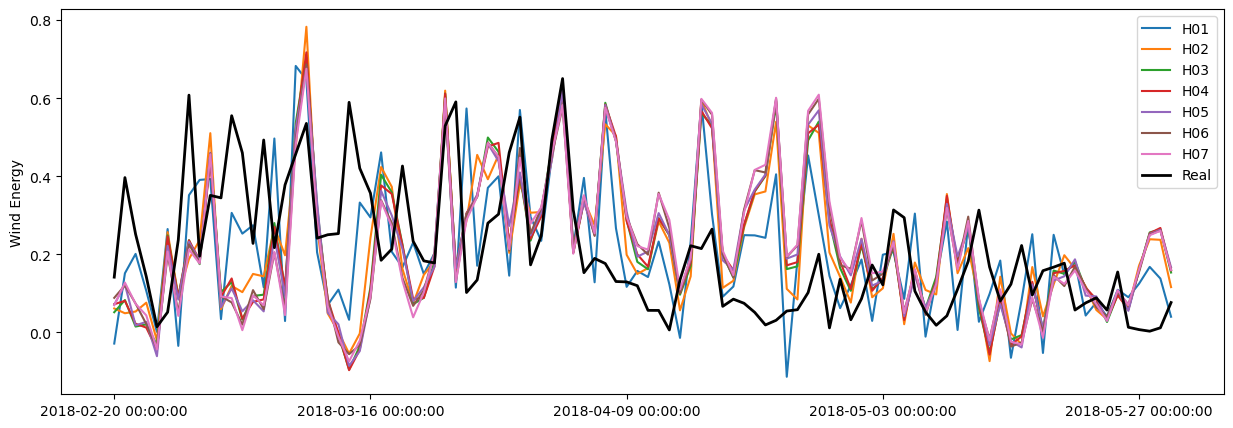

In [31]:
maes_h = []
n_horizon=7
n_hours=24

start=n_tr + n_va
end=n_tr + n_va + n_te

#Reentrenamos con todo el conjunto de entrenamiento y validación 
mod = SARIMAX_train(eolica, order, n_tr + n_va)

for h in range(n_horizon):
    file = '%s/predARval_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h)
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))
    hours, maes = errors_by_day(eolica[start:end], pred, MAE=True)
    maes_h.append(maes)
    
y = eolica[start+50:start+150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

MAE Total H01: 0.15
MAE Total H02: 0.17
MAE Total H03: 0.17
MAE Total H04: 0.17
MAE Total H05: 0.17
MAE Total H06: 0.18
MAE Total H07: 0.18


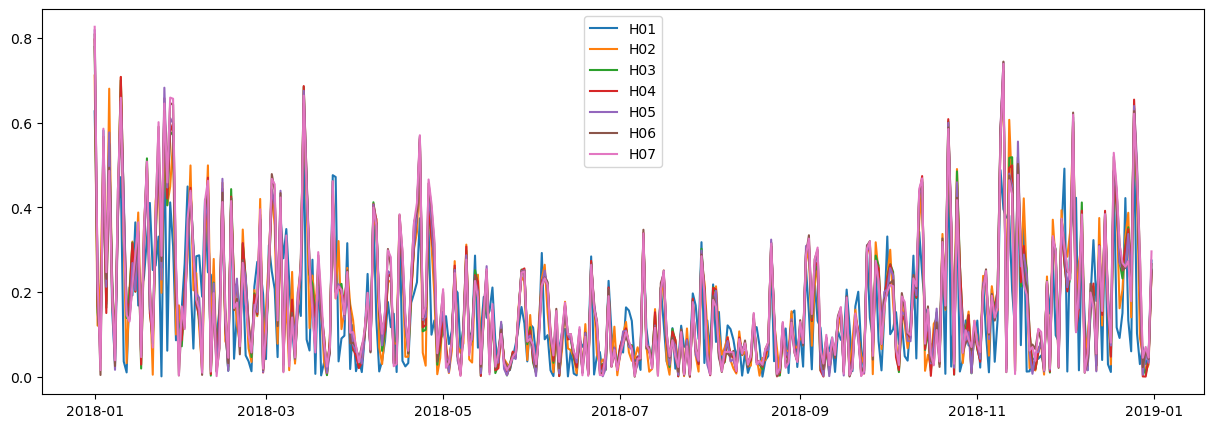

In [32]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.04757D-01    |proj g|=  1.48399D+00


 This problem is unconstrained.



At iterate    5    f= -5.50202D-01    |proj g|=  1.20221D+00

At iterate   10    f= -5.85092D-01    |proj g|=  4.61722D-01

At iterate   15    f= -6.29372D-01    |proj g|=  3.74419D-01

At iterate   20    f= -6.36994D-01    |proj g|=  3.45969D-02

At iterate   25    f= -6.37316D-01    |proj g|=  2.63190D-02

At iterate   30    f= -6.37422D-01    |proj g|=  2.60098D-02

At iterate   35    f= -6.37651D-01    |proj g|=  2.41276D-02

At iterate   40    f= -6.38162D-01    |proj g|=  2.45999D-02

At iterate   45    f= -6.39031D-01    |proj g|=  7.39451D-02


/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.40137D-01    |proj g|=  1.54920D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     67      1     0     0   1.549D-01  -6.401D-01
  F = -0.64013699282855940     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


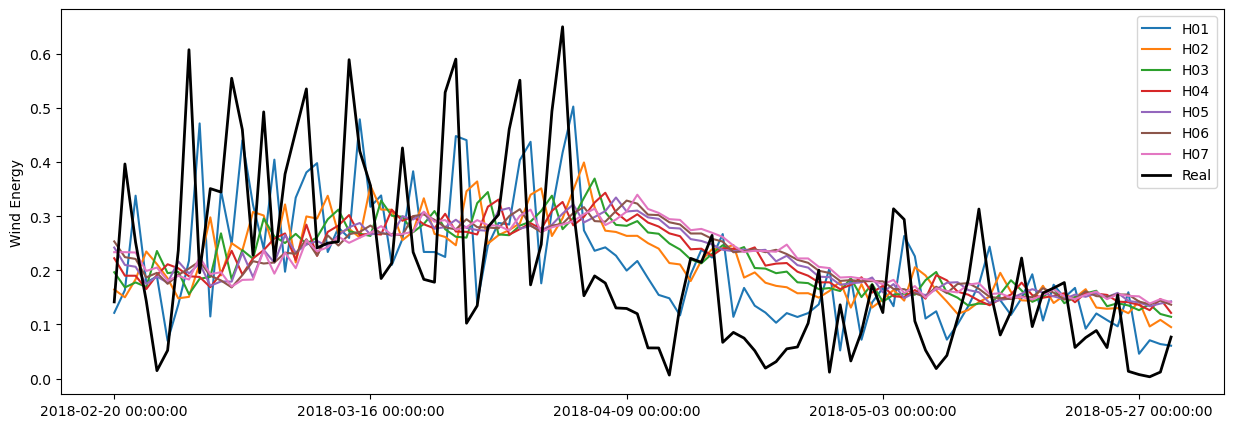

In [33]:
# Train again with the best parameters SARIMA model
order = (6, 0, 4)
seasonal_order = (1, 1, 1, 7)
mod = SARIMAX_train(eolica, order, n_tr + n_va, period=0, seasonal_order=seasonal_order)

# Predict the test set
n_horizon = 7
n_hours = 24
start = n_tr + n_va
end = n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/predAR_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))

# While predicting, plot the first 100 points as an example
y = eolica[start + 50 : start + 150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()


/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47678D+02    |proj g|=  5.59521D+03

At iterate    5    f=  1.05523D+00    |proj g|=  7.58542D-01

At iterate   10    f=  2.72814D-01    |proj g|=  1.75837D+00

At iterate   15    f= -5.33592D-01    |proj g|=  1.79374D+00

At iterate   20    f= -6.57993D-01    |proj g|=  6.19389D-01

At iterate   25    f= -6.64222D-01    |proj g|=  9.38965D-02

At iterate   30    f= -6.65254D-01    |proj g|=  4.14335D-03

At iterate   35    f= -6.65518D-01    |proj g|=  1.02239D-02

At iterate   40    f= -6.66109D-01    |proj g|=  4.28956D-02

At iterate   45    f= -6.66442D-01    |proj g|=  6.00997D-03

At iterate   50    f= -6.66476D-01    |proj g|=  3.91813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


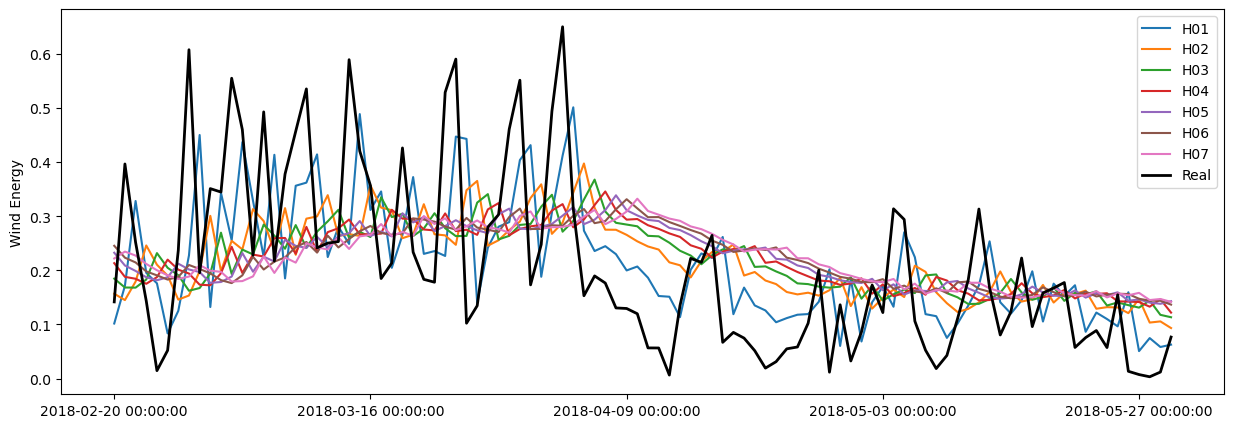

In [34]:
# Train again with the best parameters ARIMA model
order = (6, 0, 4)
mod = SARIMAX_train(eolica, order, n_tr + n_va, period=0)

# Predict the test set
n_horizon = 7
n_hours = 24
start = n_tr + n_va
end = n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/predARIMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))

# While predicting, plot the first 100 points as an example
y = eolica[start + 50 : start + 150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

In [35]:
# Arrange the exogenous variables
exog1 = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 1], dayfirst=True).squeeze()
exog2 = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 2], dayfirst=True).squeeze()

exog1 = (exog1 - exog1.min()) / (exog1.max() - exog1.min())
exog2 = (exog2 - exog2.min()) / (exog2.max() - exog2.min())

# Fill the missing values
exog1 = exog1.interpolate()
exog2 = exog2.interpolate()

exog1_tr = exog1['2016']
exog1_va = exog1['2017']
exog1_te = exog1['2018']

exog2_tr = exog2['2016']
exog2_va = exog2['2017']
exog2_te = exog2['2018']


exog = pd.concat([exog1_tr, exog2_tr], axis=1)
exog

,WindSpeed,WindDirection
Date,,
2016-01-01,0.636730,0.529248
2016-01-02,0.505469,0.604457
2016-01-03,0.851468,0.621170
2016-01-04,0.544041,0.696379
2016-01-05,0.622913,0.727019
...,...,...
2016-12-27,0.224525,0.392758
2016-12-28,0.188831,0.440111
2016-12-29,0.194588,0.298050


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36156D+00    |proj g|=  4.30154D+00

At iterate    5    f= -1.39309D+00    |proj g|=  6.31957D-01

At iterate   10    f= -1.41825D+00    |proj g|=  3.38978D-01

At iterate   15    f= -1.42797D+00    |proj g|=  8.56713D-02

At iterate   20    f= -1.43332D+00    |proj g|=  1.36037D+00

At iterate   25    f= -1.44629D+00    |proj g|=  6.77248D-02

At iterate   30    f= -1.46512D+00    |proj g|=  8.02426D-02

At iterate   35    f= -1.46725D+00    |proj g|=  3.79032D-02

At iterate   40    f= -1.46729D+00    |proj g|=  3.79927D-03

At iterate   45    f= -1.46733D+00    |proj g|=  4.33866D-02


/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.46734D+00    |proj g|=  4.40518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   4.405D-03  -1.467D+00
  F =  -1.4673396375547898     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


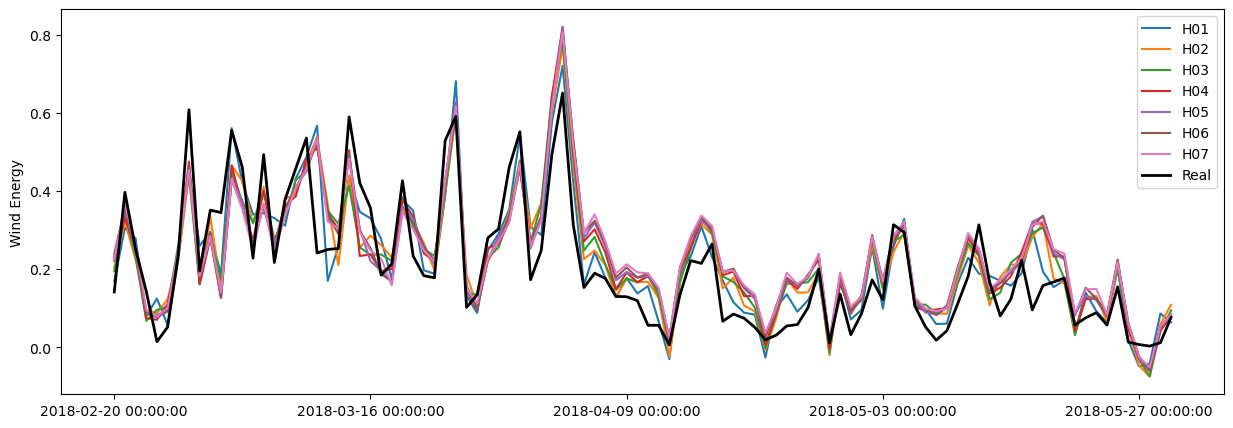

In [36]:
# Train again with the best parameters SARIMAX model
order = (6, 0, 4)
seasonal_order = (1, 1, 1, 7)
mod = SARIMAX_train(eolica, order, n_tr + n_va, period=0, seasonal_order=seasonal_order, exog=exog1)

# Predict the test set
n_horizon = 7
n_hours = 24
start = n_tr + n_va
end = n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/predSARIMAX_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))

# While predicting, plot the first 100 points as an example
y = eolica[start + 50 : start + 150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18969D+02    |proj g|=  1.55406D+04

At iterate    5    f=  1.02041D+00    |proj g|=  1.25028D+00

At iterate   10    f=  8.52350D-01    |proj g|=  1.05900D+00
  ys=-2.781E-02  -gs= 6.230E-01 BFGS update SKIPPED
  ys=-8.503E-02  -gs= 3.137E-01 BFGS update SKIPPED

At iterate   15    f= -6.83280D-01    |proj g|=  1.68547D+00

At iterate   20    f= -8.05643D-01    |proj g|=  2.98146D-01

At iterate   25    f= -1.03899D+00    |proj g|=  3.30957D-01

At iterate   30    f= -1.39859D+00    |proj g|=  1.48342D+00

At iterate   35    f= -1.40674D+00    |proj g|=  4.63762D-02

At iterate   40    f= -1.42422D+00    |proj g|=  8.43716D-02

At iterate   45    f= -1.43093D+00    |proj g|=  2.50764D-02

At iterate   50    f= -1.43397D+00    |proj g|=  1.26004D-01

           * * *

Tit   = total number of iter

/home/merve/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


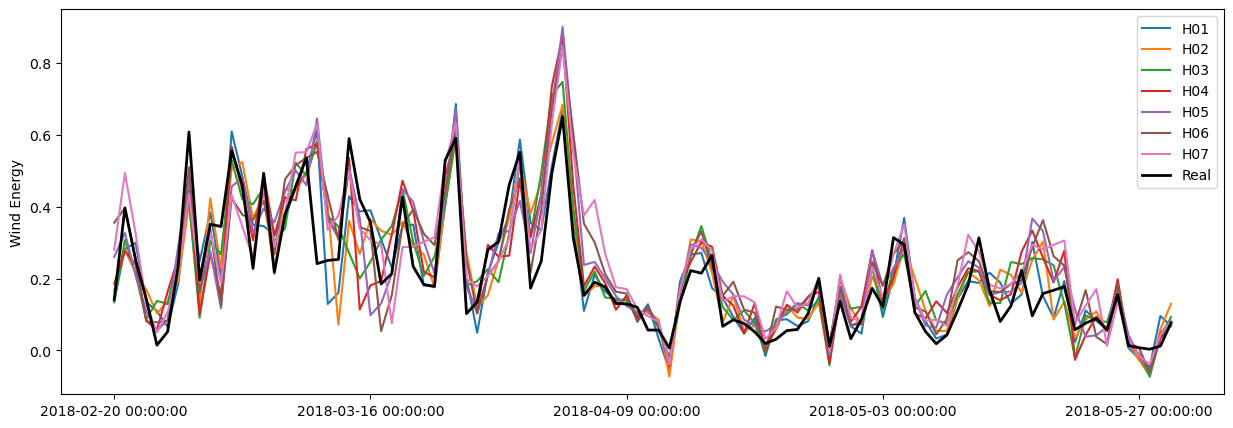

In [37]:
# Train again with the best parameters ARIMAX model
order = (6, 0, 4)
mod = SARIMAX_train(eolica, order, n_tr + n_va, period=0, exog=exog1)

# Predict the test set
n_horizon = 7
n_hours = 24
start = n_tr + n_va
end = n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/predARIMAX_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[50:150], label='H%02d' % (h + 1))

# While predicting, plot the first 100 points as an example
y = eolica[start + 50 : start + 150]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

**Como podemos ver en los gráficos, podemos obtener previsiones más precisas cuando entrenamos con SARIMAX y ARIMAX.**

In [38]:
# See the mean absolute error for each horizon
maes_h = []
n_horizon = 7
for h in range(n_horizon):
    file = f'{output_folder}/pred0_H{h:02d}.npy'
    if isfile(file):
        pred = np.load(file)
    days, maes = errors_by_day(eolica[start:end], pred, MAE=True)
    maes_h.append(maes)

horizon = 0
print('Total MAE: %.2f' % maes_h[horizon][0])
for day in days:
    print(f'MAE {day}: %.2f' % maes_h[horizon][days.index(day) + 1])


Total MAE: 0.22
MAE 2018-01-01: 0.54
MAE 2018-01-02: 0.92
MAE 2018-01-03: 0.74
MAE 2018-01-04: 0.50
MAE 2018-01-05: 1.18
MAE 2018-01-06: 0.81
MAE 2018-01-07: 0.06
MAE 2018-01-08: 0.30
MAE 2018-01-09: 0.24
MAE 2018-01-10: 0.04
MAE 2018-01-11: 0.71
MAE 2018-01-12: 0.50
MAE 2018-01-13: 0.32
MAE 2018-01-14: 0.29
MAE 2018-01-15: 0.31
MAE 2018-01-16: 0.16
MAE 2018-01-17: 0.85
MAE 2018-01-18: 0.30
MAE 2018-01-19: 0.10
MAE 2018-01-20: 0.32
MAE 2018-01-21: 0.51
MAE 2018-01-22: 0.32
MAE 2018-01-23: 0.34
MAE 2018-01-24: 0.14
MAE 2018-01-25: 0.48
MAE 2018-01-26: 0.22
MAE 2018-01-27: 0.29
MAE 2018-01-28: 0.01
MAE 2018-01-29: 0.17
MAE 2018-01-30: 0.06
MAE 2018-01-31: 0.16
MAE 2018-02-01: 0.17
MAE 2018-02-02: 0.29
MAE 2018-02-03: 0.01
MAE 2018-02-04: 0.20
MAE 2018-02-05: 0.16
MAE 2018-02-06: 0.73
MAE 2018-02-07: 0.14
MAE 2018-02-08: 0.21
MAE 2018-02-09: 0.02
MAE 2018-02-10: 0.06
MAE 2018-02-11: 0.06
MAE 2018-02-12: 0.34
MAE 2018-02-13: 0.32
MAE 2018-02-14: 0.16
MAE 2018-02-15: 0.91
MAE 2018-02-16: 0.

Además, los errores son mucho menores. Por lo tanto, los modelos ARIMAX y SARIMAX nos dan mejores resultados.

# Comparación frente a modelos multivariantes convencionales [Opcional, +1 punto]

**Ejercicio:**
    
* Comparar los modelos de ST probados con un modelo clásico de aprendizaje automático como una SVM o una red neuronal, entrenado con los patrones meteorológicos y con la energía 	eólica como salida.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.utils import set_random_seed


2024-06-30 04:23:48.278765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
def create_rnn():
    set_random_seed(123)

    rnn = Sequential()
    rnn.add(LSTM(200, input_shape=(24, 1)))
    rnn.add(Dropout(0.4, input_shape=(1,)))
    rnn.add(Dense(100))
    rnn.add(Dense(50))
    rnn.add(Dense(24))
    rnn.add(Dense(1))
    rnn.compile(loss="mean_squared_error", optimizer="SGD", metrics=["mean_absolute_error"])
    return rnn

In [41]:
def create_dataset(s, h=0, batch_size=32):
    y = s[h+1:]
    x = s[:-(h+1)]
    
    x = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
    
    x, y = x.reshape(-1, 1), y.to_numpy().reshape(-1, 1)
    dataset = timeseries_dataset_from_array(x, y, sequence_length=24, 
                                            batch_size=batch_size)

    dataset_tr = dataset.take(int((n_tr + n_va) / batch_size))
    dataset_te = dataset.skip(int((n_tr + n_va) / batch_size))
    y_te = np.concatenate([batch[1].numpy() for batch in dataset_te])
    
    return dataset_tr, dataset_te, y_te

In [42]:
dataframe = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 1], dayfirst=True)

In [43]:
# Apply Normalization
PI = 17560
dataframe = dataframe / (PI*24)

# Apply Interpolation
dataframe = dataframe.interpolate()

# Apply rnn model

dataset_tr, dataset_te, y_te = create_dataset(dataframe, h=0, batch_size=16)

rnn = create_rnn()
rnn.fit(dataset_tr, epochs=50)

y_pred = rnn.predict(dataset_te)
mae = mean_absolute_error(y_te, y_pred)

print(f'MAE: {mae:.2f}')

# See the mean absolute error for each horizon
maes_h = []
n_horizon = 7
for h in range(n_horizon):
    dataset_tr, dataset_te, y_te = create_dataset(dataframe, h=h, batch_size=16)
    y_pred = rnn.predict(dataset_te)
    maes_h.append(mean_absolute_error(y_te, y_pred))
    print(f'MAE H{h+1:02d}: {maes_h[h]:.2f}')



2024-06-30 04:23:49.390707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-06-30 04:23:49.456761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_28}}]]
2024-06-30 04:23:49.457077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_28}}]]


Epoch 1/50


2024-06-30 04:23:49.672205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-30 04:23:49.673132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-30 04:23:49.673844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 3s 44ms/step - loss: 6.7188e-04 - mean_absolute_error: 0.0192
Epoch 2/50
45/45 [==============================] - 1s 31ms/step - loss: 6.7425e-04 - mean_absolute_error: 0.0187
Epoch 3/50
45/45 [==============================] - 4s 88ms/step - loss: 5.8739e-04 - mean_absolute_error: 0.0177
Epoch 4/50
45/45 [==============================] - 2s 42ms/step - loss: 5.4114e-04 - mean_absolute_error: 0.0169
Epoch 5/50
45/45 [==============================] - 2s 40ms/step - loss: 4.6892e-04 - mean_absolute_error: 0.0158
Epoch 6/50
45/45 [==============================] - 3s 65ms/step - loss: 4.5103e-04 - mean_absolute_error: 0.0152
Epoch 7/50
45/45 [==============================] - 2s 43ms/step - loss: 4.0506e-04 - mean_absolute_error: 0.0147
Epoch 8/50
45/45 [==============================] - 3s 57ms/step - loss: 4.1921e-04 - mean_absolute_error: 0.0147
Epoch 9/50
45/45 [==============================] - 2s 36ms/step - loss: 3.6581e-04 - mean_absolute

2024-06-30 04:26:12.830119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-30 04:26:12.831127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-30 04:26:12.831963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 8ms/step
MAE: 0.00
 4/22 [====>.........................] - ETA: 0s

2024-06-30 04:26:13.249948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1095,1]
	 [[{{node Placeholder/_20}}]]
2024-06-30 04:26:13.252965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_8}}]]


22/22 [==============================] - 0s 10ms/step
MAE H01: 0.00
 7/22 [========>.....................] - ETA: 0s

2024-06-30 04:26:13.758227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1071]
	 [[{{node Placeholder/_8}}]]
2024-06-30 04:26:13.761350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1071]
	 [[{{node Placeholder/_28}}]]


22/22 [==============================] - 0s 8ms/step
MAE H02: 0.00
 1/22 [>.............................] - ETA: 1s

2024-06-30 04:26:14.140022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2024-06-30 04:26:14.140500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1093,1]
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 0s 14ms/step
MAE H03: 0.00
 1/22 [>.............................] - ETA: 1s

2024-06-30 04:26:14.669947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1092,1]
	 [[{{node Placeholder/_0}}]]
2024-06-30 04:26:14.670585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1092,1]
	 [[{{node Placeholder/_20}}]]


22/22 [==============================] - 0s 9ms/step
MAE H04: 0.00
 9/22 [===========>..................] - ETA: 0s

2024-06-30 04:26:15.198907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1091,1]
	 [[{{node Placeholder/_20}}]]
2024-06-30 04:26:15.203009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


22/22 [==============================] - 0s 8ms/step
MAE H05: 0.00
 1/22 [>.............................] - ETA: 1s

2024-06-30 04:26:15.557836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1067]
	 [[{{node Placeholder/_8}}]]
2024-06-30 04:26:15.559374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


22/22 [==============================] - 0s 10ms/step
MAE H06: 0.00
 1/22 [>.............................] - ETA: 1s

2024-06-30 04:26:16.034252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1089,1]
	 [[{{node Placeholder/_20}}]]
2024-06-30 04:26:16.036813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


22/22 [==============================] - 0s 16ms/step
MAE H07: 0.00


Dado que el error cuadrático medio no es muy bajo, pero el error absoluto es bajo (cercano a cero), podemos decir que cuando los datos se entrenan con recurrentes red neronal, hace predicciones aproximadamente precisas.